# Notebook for analyzing correlation between nyiso load data and twitter for sandy.

The nyiso load data is standardized to data from the year 2012.

In [2]:
%matplotlib inline
import sys
import os
sys.path.append(os.path.abspath('../'))

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
import scipy.signal
import seaborn as sns
sns.set()

from twitterinfrastructure.tools import connect_db, output, query
import twitterinfrastructure.analysis as asys
import twitterinfrastructure.nyiso as pw
import twitterinfrastructure.twitter_sandy as ts

import importlib
importlib.reload(asys)
importlib.reload(pw)
importlib.reload(ts)

#os.chdir('../')
print(os.getcwd())

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **{'family': "serif"})
params = {'text.latex.preamble': [r'\usepackage{siunitx}', 
                                  r'\usepackage{amsmath}']}
plt.rcParams.update(params)
sns.set_context('paper')
sns.set_style('darkgrid')

C:\dev\research\socialsensing\notebooks


## Load data to analyze correlation between hourly zone loads and sandy tweets.

Data is grouped by hour and zone. Loading takes ~1 minute.

In [4]:
tweet_count_filter = 5  # by day

db_path = 'E:/Work/projects/twitterinfrastructure/data/processed/nyiso-2012.db'
startdate = pd.Timestamp('2012-10-28 00:00:00', 
                         tz='America/New_York')  # inclusive
enddate = pd.Timestamp('2012-11-03 00:00:00', 
                       tz='America/New_York')  # exclusive

# load nyiso load data (filtered by dates, grouped by zone-hour)
df_load = asys.load_nyiso(startdate, enddate, db_path, verbose=1)

# load normalized sandy-related tweets (filtered by dates, grouped by zone-hour)
df_tweets = ts.query_groupby_hour_norm('tweets_sandy', 'tweets_analysis', 
                                       'nyiso_zone', tweet_count_filter, 
                                       startdate=startdate, enddate=enddate, 
                                       verbose=2)
df_tweets = df_tweets.rename(columns={'tweets': 'sandy-tweets', 
                                      'tweets-norm': 'sandy-tweets-norm'})

# combine into one dataframe
df_tweets.index.names = ['nyiso_zone', 'datetimeNY']    # temp (merge)
df_tweets = df_tweets.rename(index={'A': 1, 'B': 2, 'C': 3, 'D': 4,
                                    'E': 5, 'F': 6, 'G': 7, 'H': 8,
                                    'I': 9, 'J': 10, 'K': 11})
df = pd.merge(df_load, df_tweets, how='left', left_index=True, right_index=True)

# replace infinite values with nan
df = df.replace([np.inf, -np.inf], np.nan)

# export hourly dataframe to csv
print('Dataframe rows: ' + str(df.shape[0]))
# path = 'data/processed/nyisosummary_zone_hour.csv'
# df.to_csv(path, index_label=['zone', 'datetimeNY'])

2019-05-27 19:23:01 : Started query.

2019-05-27 19:23:02 : [min, max] forecast error datetimeNY: [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2019-05-27 19:23:02 : [min, max] forecast error: [-0.3133047210300429, 3.3987975951903806].

2019-05-27 19:23:02 : Finished query.

2019-05-27 19:23:02 : Started query.

2019-05-27 19:23:02 : Started query.



AttributeError: 'NoneType' object has no attribute 'keys'

## Analyze correlation between hourly zone loads and sandy tweets.

Data is grouped by hour and zone.

zone data points: 
nyiso_zone
10    120
11     98
7      70
9      57
1      47
3      43
6      41
2      33
5      30
8       9
4       0
Name: sandy-tweets-norm, dtype: int64
Cross-correlation for zone 10 with lag 0: 0.05175622119559351
Time series length: 120.

Cross-correlation for zone 10 with lag -23: 0.6418575679652969
Time series length: 97.

lags giving max rho:
nyiso_zone
1.0    -14.0
2.0    -14.0
3.0    -16.0
6.0    -10.0
7.0    -16.0
9.0    -26.0
10.0   -23.0
11.0   -15.0
Name: max-lags, dtype: float64

max rho:
nyiso_zone
1.0     0.569568
2.0     0.513374
3.0     0.516346
6.0     0.519968
7.0     0.574472
9.0     0.462295
10.0    0.641858
11.0    0.545488
dtype: float64



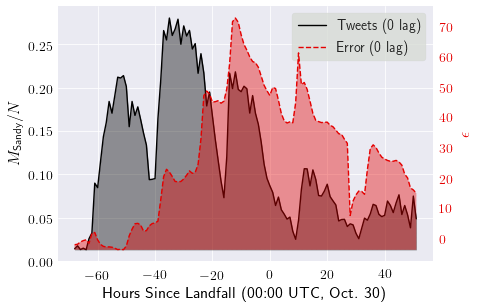

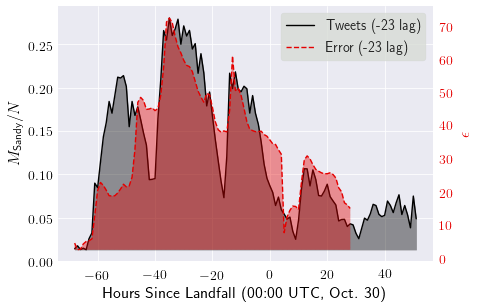

In [3]:
# calculate cross-correlation for various load time shifts
min_row = 10
ploty1 = 'sandy-tweets-norm'
ploty2 = 'percent-err0'
df_ts = df[[ploty1, ploty2]].dropna()
counts = df_ts.count(level='nyiso_zone')[ploty1]
counts = counts.sort_values(ascending=False)
print('zone data points: ')
print(counts)
# top_counts = counts[0:5]
# print('zones with the most data points: ')
# print(top_counts)
# print('')
# zones = [10, 11, 7]
zones = [1, 2, 3, 6, 7, 9, 10, 11]
# zones = [6, 7]
# zones = pd.unique(df.index.get_level_values(level=0))

# reindex on timedelta
df_td = df.copy()
df_td['timedelta'] = df_td.index.get_level_values('datetimeNY') - \
                      pd.Timestamp('2012-10-30 20:00:00', tz='America/New_York')
df_td['timedelta'] = [int(td.total_seconds() / 3600) for td 
                      in df_td['timedelta']]
df_td = df_td.reset_index()
df_td = df_td.set_index(['nyiso_zone', 'timedelta'])
df_td = df_td[[ploty1, ploty2]]
df_td = df_td.sort_index(level=0)

# calculate cross-correlation for various time lags (on load)
df_rho = pd.DataFrame(columns=['lag', 'nyiso_zone', 'rho'])
df_count = pd.DataFrame(columns=['lag', 'nyiso_zone', 'count'])
lags = list(reversed(range(-48, 1)))
# plt_combos = [(0, 10), (-20, 10), (-20, 11), (-20, 7)]
plt_combos = [(0, 10), (-23, 10)]
for lag in lags:
    for zone in zones:
        df_zone = df_td.xs(zone, level=0)
        if df_zone.dropna().shape[0] < min_row:
            df_rho = df_rho.append({'lag': lag, 'nyiso_zone': zone, 
                                    'rho': np.nan}, ignore_index=True)
            print('skipping (lag, zone): ({lag}, {zone})'.format(lag=lag, 
                                                                 zone=zone))
            print('')
            continue
        
        df_both = df_zone.dropna()
        df_plt1 = df_zone[ploty1].dropna()
        df_plt2 = df_zone[ploty2].dropna()

        # interpolate to create time series
        timedeltas = range(min(df_both.index.values),
                           max(df_both.index.values))
        ploty1_int = np.interp(timedeltas, df_plt1.index.values, df_plt1.values)
        plotx1 = timedeltas
        ploty2_int = np.interp(timedeltas, df_plt2.index.values, df_plt2.values)
        plotx2 = timedeltas[0:(len(timedeltas) + lag)]
        ploty2_int = ploty2_int[-lag::]

        # normalized cross-correlation
        a = ploty1_int
        b = ploty2_int
        a = (a - np.mean(a)) / (np.std(a) * len(a))
        b = (b - np.mean(b)) / (np.std(b))
        rho = np.correlate(a, b, mode='valid')[0]

        df_rho = df_rho.append({'lag': lag, 'nyiso_zone': zone, 'rho': rho}, 
                               ignore_index=True)
        df_count = df_count.append({'lag': lag, 'nyiso_zone': zone, 
                                    'count': len(ploty2_int)}, 
                                   ignore_index=True)

        # figure
        if (lag, zone) in plt_combos:
            fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=False)
            ax2 = ax1.twinx()
            ax2.grid(None)
            linestyles = ['-', '--', ':']
            lines = []

            # shaded line plots for current zone
            line = ax1.plot(plotx1, ploty1_int, 
                            color='xkcd:black', linestyle=linestyles[0])
            ax1.fill_between(plotx1, ploty1_int, y2=min(ploty1_int), 
                             color='xkcd:black', linestyle=linestyles[0], 
                             alpha=0.4)
            lines.append(line[0])
            line = ax2.plot(plotx2, ploty2_int, 
                            color='xkcd:red', linestyle=linestyles[1])
            ax2.fill_between(plotx2, ploty2_int, y2=min(ploty2_int),
                             color='xkcd:red', linestyle=linestyles[1], 
                             alpha=0.4)
            lines.append(line[0])

            # axes
            fig.tight_layout()
            ax1.tick_params(axis='both', colors='k', labelsize=14)
            ax1.set_xlabel('Hours Since Landfall (00:00 UTC, Oct. 30)', 
                           color='k', size=16)
            ax1.set_ylabel(ploty1, color='k', size=16)
            ax2.tick_params(axis='y', labelcolor='xkcd:red', labelsize=14)
            ax2.set_ylabel(ploty2, color='xkcd:red', size=16)
            
            print('Cross-correlation for zone {zone} with lag {lag}: {rho}'.format(
                zone=zone, lag=lag, rho=rho))
            print('Time series length: {len}.'.format(len=len(b)))
            print('')
            
            # save
            ax1.set_ylabel(r'$M_{\text{Sandy}}/N$', color='k', size=16)
            ax2.set_ylabel(r'$\epsilon$', color='xkcd:red', size=16)
            labels = ['Tweets ({lag} lag)'.format(z1=zone, lag=lag), 
                      'Error ({lag} lag)'.format(z1=zone, lag=lag)]
            leg = ax1.legend(handles=lines, labels=labels, loc='best', 
                             fontsize=14, frameon=True, fancybox=True, 
                             facecolor='xkcd:light grey')
            # plt.savefig('notebooks/images/nyiso-{lag}-{zone}'
            #             '-timeseries.png'.format(lag=abs(lag), zone=zone),
            #             dpi=150, bbox_inches='tight')
df_rho = df_rho.set_index(['lag', 'nyiso_zone'])

df_rho_reshape = df_rho.reset_index()
df_rho_reshape = df_rho_reshape.pivot(index='lag', columns='nyiso_zone', 
                                      values='rho')
df_rho_reshape.head()
max_lags = df_rho_reshape.idxmax(axis=0)
max_lags.name = 'max-lags'
print('lags giving max rho:')
print(max_lags)
print('')
print('max rho:')
print(df_rho_reshape.max(axis=0))
print('')

df_count_reshape = df_count.reset_index()
df_count_reshape = df_count_reshape.pivot(index='lag', columns='nyiso_zone',
                                          values='count')
# print('num points used:')
# print(df_rho_reshape.max(axis=0))
# print('')

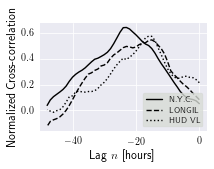

In [4]:
# plot cross-correlations vs. time lag
linestyles = ['-', '--', ':']
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=False)
plt_zones = [10, 11, 7]
for i, zone in enumerate(plt_zones):
    df_zone = df_rho.xs(zone, level=1)
    plotx = df_zone.index.values
    ploty = df_zone['rho']
    line = ax.plot(plotx, ploty, color='xkcd:black', linestyle=linestyles[i])

# replace zone_id with zone abbrev
zones_path = 'data/raw/nyiso/nyiso-zones.csv'
df_zones = pd.read_csv(zones_path)
zones = dict(zip(df_zones['zone_id'], df_zones['name']))
zone_names = [zones[zone] for zone in plt_zones]

ax.set_xlabel(r'Lag $n$ [hours]', color='k', size=12)
ax.set_ylabel(r'Normalized Cross-correlation', color='k', size=12)
ax.tick_params(labelcolor='k', labelsize=10)
leg = ax.legend(zone_names, loc='lower right', fontsize=8,
                frameon=True, fancybox=True, facecolor='xkcd:light grey')

# save
fig.set_size_inches(3, 2)
plt.savefig('notebooks/images/report/nyiso-lagccr.png', dpi=150, 
            bbox_inches='tight')

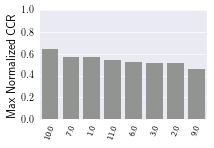

In [5]:
# plot hourly cross-correlations for all zones
max_rhos = df_rho_reshape.max(axis=0)
max_rhos.name = 'max-rho'
df_plt = max_rhos.reset_index()
df_plt = df_plt.sort_values('max-rho', ascending=False)

# replace zone_id with zone abbrev
zones_path = 'data/raw/nyiso/nyiso-zones.csv'
df_zones = pd.read_csv(zones_path)
zones = dict(zip(df_zones['zone_id'], df_zones['name']))
df_plt['zone'] = df_plt['nyiso_zone'].replace(zones)

# figure, barplot, and axes
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=False)
# sns.barplot(x='max-rho', y='zone', data=df_plt, color='xkcd:grey', ax=ax, 
#             orient='h', order=df_plt['zone'])
# ax.tick_params(axis='x', colors='k', labelsize=10)
# ax.tick_params(axis='y', colors='k', labelsize=7)
# ax.set_xlabel(r'Max Normalized Cross-correlation', color='k', size=12)
# ax.set_ylabel('')
# ax.set(xlim=(0, 1))
sns.barplot(y='max-rho', x='nyiso_zone', data=df_plt, color='xkcd:grey', ax=ax, 
            orient='v', order=df_plt['nyiso_zone'])
ax.tick_params(axis='x', colors='k', labelsize=8)
ax.tick_params(axis='y', colors='k', labelsize=10)
plt.xticks(rotation=70)
ax.set_ylabel(r'Max Normalized CCR', color='k', size=12)
ax.set_xlabel('')
ax.set(ylim=(0, 1))

# save
fig.set_size_inches(3, 2)
plt.savefig('notebooks/images/report/nyiso-hourlyccr-bar.png', 
            dpi=150, 
            bbox_inches='tight')